## Часть первая, с блекджеком и стратегиями

Мы будем обучаться играть в очень простую, но всё-таки знаменитую и популярную игру: блекджек.\
Правила блекджека достаточно просты; давайте начнём с самой базовой версии, которая реализована в OpenAI Gym:
- численные значения карт равны от 2 до 10 для карт от двойки до десятки, 10 для валетов, дам и королей;
- туз считается за 11 очков, если общая сумма карт на руке при этом не превосходит 21 (по-английски в этом случае говорят, что на руке есть usable ace), и за 1 очко, если превосходит (11 пока общая сумма не больше 21, далее 1);
- игроку раздаются две карты, дилеру — одна в открытую и одна в закрытую;
- игрок может совершать одно из двух действий:
-- hit  — взять ещё одну карту;
-- stand — не брать больше карт;
- если сумма очков у игрока на руках больше 21, он проигрывает (bust);
- если игрок выбирает stand с суммой не больше 21, дилер добирает карты, пока сумма карт в его руке меньше 17;
- после этого игрок выигрывает, если дилер либо превышает 21, либо получает сумму очков меньше, чем сумма очков у игрока; при равенстве очков объявляется ничья (ставка возвращается);
- в исходных правилах есть ещё дополнительный бонус за natural blackjack: если игрок набирает 21 очко с раздачи, двумя картами, он выигрывает не +1, а +1.5 (полторы ставки).

Именно этот простейший вариант блекджека реализован в OpenAI Gym:\
https://github.com/openai/gym/blob/38a1f630dc9815a567aaf299ae5844c8f8b9a6fa/gym/envs/toy_text/blackjack.py


In [181]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from IPython import display

import gym

env = gym.make('Blackjack-v0', natural=True)

### 1. Рассмотрим очень простую стратегию: говорить stand, если у нас на руках комбинация в 19, 20 или 21 очко, во всех остальных случаях говорить hit. Используйте методы Монте-Карло, чтобы оценить выигрыш от этой стратегии.


In [31]:
def simple_policy(sum_hand):
  if 18 < sum_hand < 22:
    return STAND
  return HIT

def play_game(env, policy):

In [138]:
num_experiments = 10
num_games = 100000

rewards = np.zeros((num_experiments, num_games))

for i in range(num_experiments):
  for j in range(num_games):
    sum_hand, dealer_card, usable_ace = env.reset()
    done = False
    while not done:
      action = simple_policy(sum_hand)
      (sum_hand, dealer_card, usable_ace), reward, done, _ = env.step(action)
    rewards[i, j] += reward

In [139]:
# Средний выигрыш за одну игру
rewards.mean()

-0.1812565

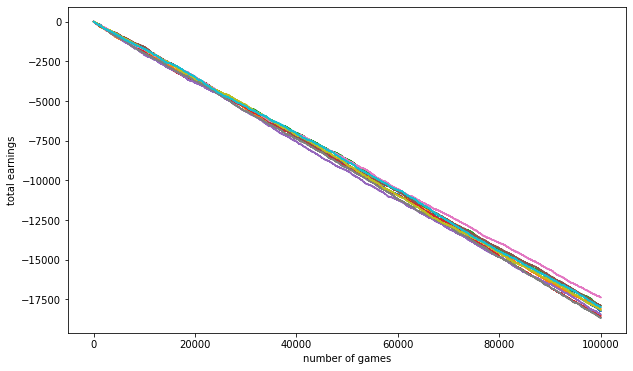

In [142]:
total_earnings = np.cumsum(rewards, axis=1)

plt.figure(figsize=(10, 6))
for i in range(num_experiments):
  plt.plot(np.arange(1, num_games + 1), total_earnings[i])
plt.xlabel('number of games')
plt.ylabel('total earnings');

### 2. Реализуйте метод обучения с подкреплением без модели (можно Q-обучение, но рекомендую попробовать и другие, например Monte Carlo control) для обучения стратегии в блекджеке, используя окружение Blackjack-v0 из OpenAI Gym.

In [194]:
# Возможные состояния представляют собой произведение состояний следующих
# трех величин:
#   sum_hand: от 4 до 21 -- 18 сост
#   usable_ace: True/False -- 2 сост
#   dealer_card: от 1 до 10 -- 10 сост
# плюс еще одно состояние, когда sum_hand > 21

nS = 18 * 2 * 10 + 1
nA = 2 # hit=1, stand=0

def get_state(sum_hand, dealer_card, usable_ace):
    if sum_hand > 21:
      return nS - 1
    return (dealer_card - 1) * 36 + usable_ace * 18 + (sum_hand - 4)


def get_random_Q():
  Q = np.random.random(size=(nS, nA))
  Q[nS - 1, :] = 0.0
  return Q


def compute_policy_by_Q(Q):
  return np.argmax(Q, axis=1)


def Q_learning_episode(env, pi, Q, results, alpha=0.05, epsilon=0.0, gamma=0.9):

  sum_hand, dealer_card, usable_ace = env.reset()

  s = get_state(sum_hand, dealer_card, usable_ace)
  a = pi[s] if np.random.rand() > epsilon else np.random.randint(nA)

  done = False

  while not done:
    (sum_hand, dealer_card, usable_ace), reward, done, _ = env.step(a) ########## reward rewards[i, j] += reward
    s_prime = get_state(sum_hand, dealer_card, usable_ace)
    a_prime = pi[s_prime] if np.random.rand() > epsilon else np.random.randint(nA)
    Q[s, a] = Q[s, a] + alpha * (reward + gamma * np.max( Q[s_prime] ) - Q[s, a])
    s, a = s_prime, a_prime
  
  results.append(reward)

In [244]:
total_episodes = 5000000
n_s = []
avg_results = []

Q = get_random_Q()
pi = compute_policy_by_Q(Q)

results = []

for n in range(total_episodes):
  

  Q_learning_episode(env, pi, Q, results, alpha=0.02, epsilon=0.05, gamma=1.)
  pi = compute_policy_by_Q(Q)

  if n == 1000:
    avg_results.append(sum(results) / len(results))
    n_s.append(n)

  if (n + 1) % 100000 == 0:
    avg_results.append(sum(results) / len(results))
    results.clear()
    n_s.append(n)

### 3. Сколько выигрывает казино у вашей стратегии? Нарисуйте графики среднего дохода вашего метода (усреднённого по крайней мере по 100000 раздач, а лучше больше) по ходу обучения. Попробуйте подобрать оптимальные гиперпараметры.

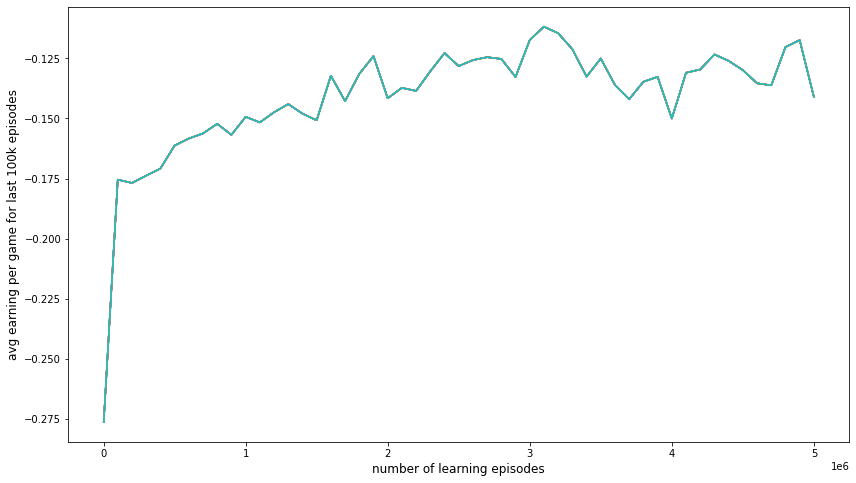

In [245]:
plt.figure(figsize=(14, 8))
for i in range(num_experiments):
  plt.plot(n_s, avg_results)
plt.xlabel('number of learning episodes', fontsize=12)
plt.ylabel('avg earning per game for last 100k episodes', fontsize=12);

## Часть вторая, удвоенная

В базовый блекджек, описанный в предыдущем разделе, обыграть казино вряд ли получится. Но, к счастью, на этом история не заканчивается. Описанные выше правила были упрощёнными, а на самом деле у игрока есть ещё и другие возможности. Реализовывать split может оказаться непросто, поэтому давайте ограничимся удвоением ставки. Итак, у игрока появляется дополнительное действие:

- double — удвоить ставку; при этом больше действий делать нельзя, игроку выдаётся ровно одна дополнительная карта, а выигрыш или проигрыш удваивается.

### 4. Реализуйте новый вариант блекджека на основе окружения Blackjack-v0 из OpenAI Gym, в котором разрешено удвоение ставки.

см. файл [blackjack_with_doubling.py](https://github.com/7CD/made_RL/tree/master/hw1/blackjack_with_doubling.py)

### 5. Реализуйте метод обучения с подкреплением без модели для этого варианта, постройте графики, аналогичные п.2.

In [255]:
import blackjack_with_doubling as bjd

env = bjd.BlackjackEnv(True)

nA = 3 # hit=1, double=2, stand=0

In [253]:
total_episodes = 5000000
n_s = []
avg_results = []

Q = get_random_Q()
pi = compute_policy_by_Q(Q)

results = []

for n in range(total_episodes):
  
  Q_learning_episode(env, pi, Q, results, alpha=0.02, epsilon=0.05, gamma=1.)
  pi = compute_policy_by_Q(Q)

  if n == 1000:
    avg_results.append(sum(results) / len(results))
    n_s.append(n)

  if (n + 1) % 100000 == 0:
    avg_results.append(sum(results) / len(results))
    results.clear()
    n_s.append(n)

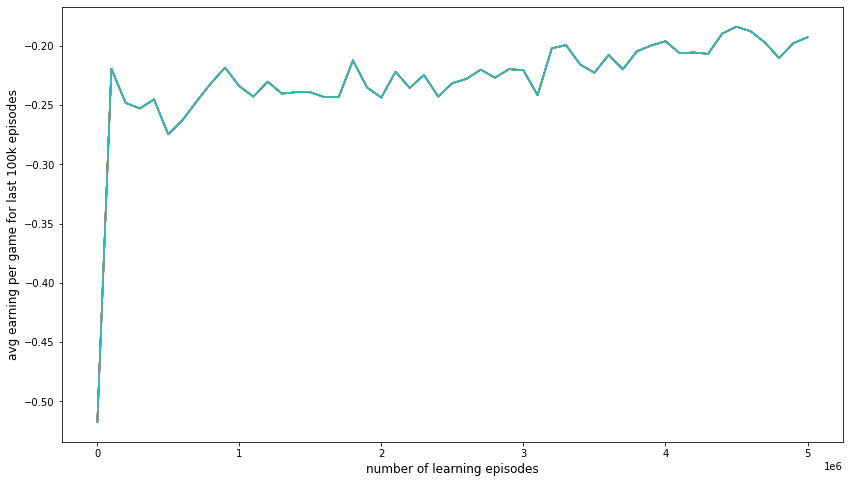

In [254]:
plt.figure(figsize=(14, 8))
for i in range(num_experiments):
  plt.plot(n_s, avg_results)
plt.xlabel('number of learning episodes', fontsize=12)
plt.ylabel('avg earning per game for last 100k episodes', fontsize=12);